## Noisy Data

Real measurement data is noisy. The entity of the noise also influences the prediction uncertainty. Therefore, it is important to consider the noisy measurements, not only the ideal noiseless case. 

In the original paper, Shuai considers different noisy cases. Let's load and inspect these.

In [2]:
import os, sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt



## add the root directory of the project to the system path
# name __file__ is not defined in the interactive mode
root_dir = Path(os.getcwd()).parent
sys.path.append(str(root_dir))


In [3]:
from pinn_buck.h5_funcs import explore_h5

db_dir = Path(r"C:\Users\JC28LS\OneDrive - Aalborg Universitet\Desktop\Work\Databases")
db_name = "buck_converter_Shuai_processed.h5"

explore_h5(db_dir / db_name)

[1] Group   10 noise
	[2] Group   10 noise/subtransient_1
		[3] Dataset 10 noise/subtransient_1/Dswitch - shape: (239,), dtype: int32
		[3] Dataset 10 noise/subtransient_1/dt - shape: (239,), dtype: float64
		[3] Dataset 10 noise/subtransient_1/i - shape: (239,), dtype: float64
		[3] Dataset 10 noise/subtransient_1/t - shape: (239,), dtype: float64
		[3] Dataset 10 noise/subtransient_1/v - shape: (239,), dtype: float64
	[2] Group   10 noise/subtransient_2
		[3] Dataset 10 noise/subtransient_2/Dswitch - shape: (239,), dtype: int32
		[3] Dataset 10 noise/subtransient_2/dt - shape: (239,), dtype: float64
		[3] Dataset 10 noise/subtransient_2/i - shape: (239,), dtype: float64
		[3] Dataset 10 noise/subtransient_2/t - shape: (239,), dtype: float64
		[3] Dataset 10 noise/subtransient_2/v - shape: (239,), dtype: float64
	[2] Group   10 noise/subtransient_3
		[3] Dataset 10 noise/subtransient_3/Dswitch - shape: (239,), dtype: int32
		[3] Dataset 10 noise/subtransient_3/dt - shape: (239,), dtyp

## Sync Error Case

It is not clear what the noise of the Sync error is. If we inspect the current and voltage signals we see no difference with respect to the ideal case.

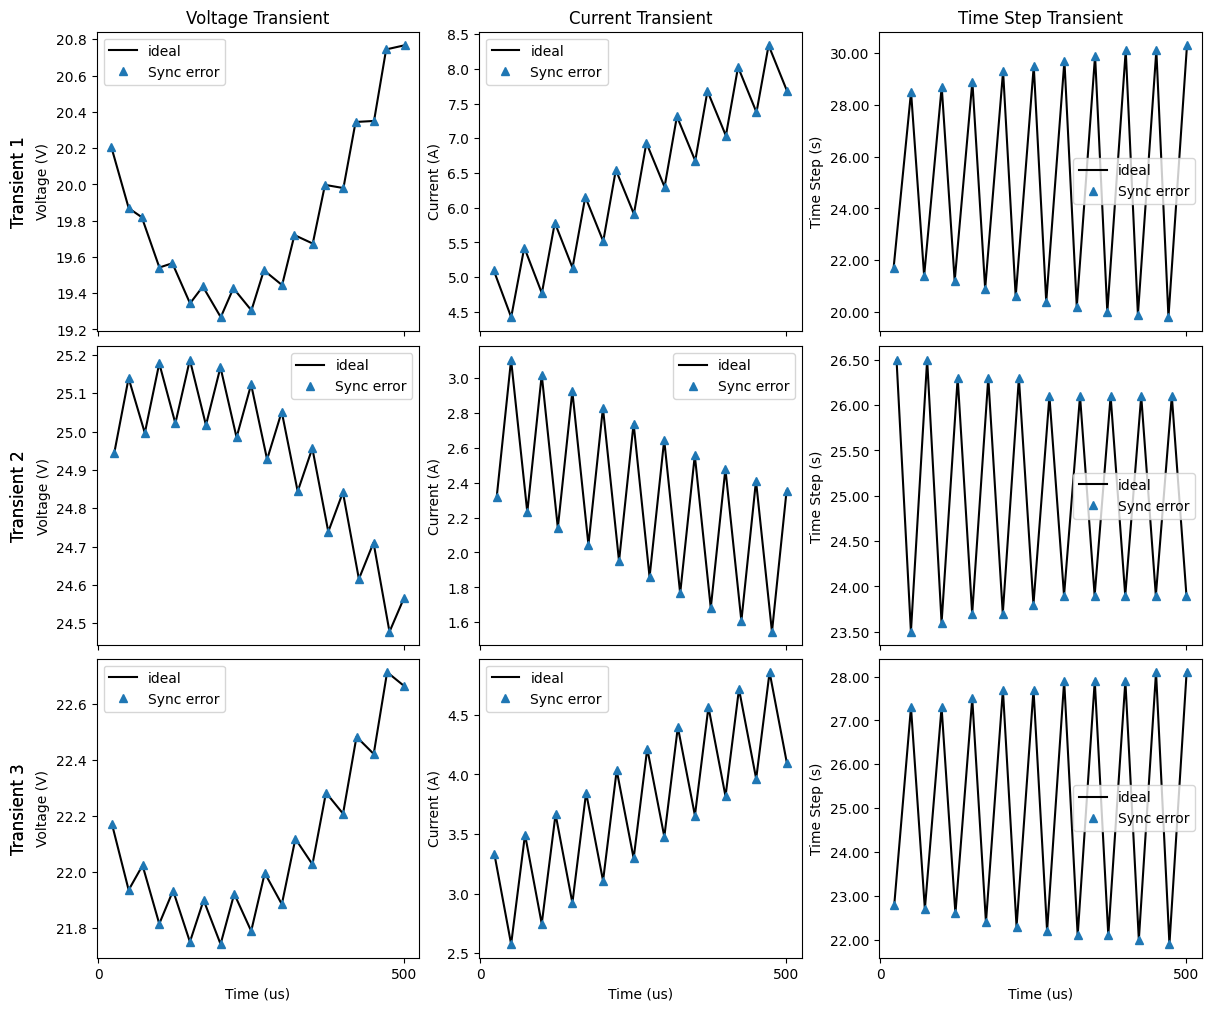

In [4]:
from pinn_buck.io import LoaderH5
from pinn_buck.constants import MeasurementGroupArchive

ideal_sim = LoaderH5(db_dir, db_name)
ideal_sim.load(measurement_name="ideal")

sync_sim = LoaderH5(db_dir, db_name)
sync_sim.load(measurement_name="Sync Error")


# noise5_sim = LoaderH5(db_dir, db_name)
# noise5_sim.load(measurement_name="5 noise")

# noise10_sim = LoaderH5(db_dir, db_name)
# noise10_sim.load(measurement_name="10 noise")


slice_index = slice(0, 20)

ax = ideal_sim.M.plot_data(
    label="ideal",
    sharex=True,
    slice_index=slice_index,
    # include_D=True,
    # D_weight=1,
    legend=True,
    figsize=(12, 10),
    # legend_loc="upper left",
    color="black",
)

sync_sim.M.plot_data(
    label="Sync error", ax=ax, slice_index=slice_index, legend=True, markers="^", linestyle=" "
);



Let us ignore the "Sync" measurements for now, we can focus on the 'ADC_error', '5 noise' and '10 noise' for the moment. 

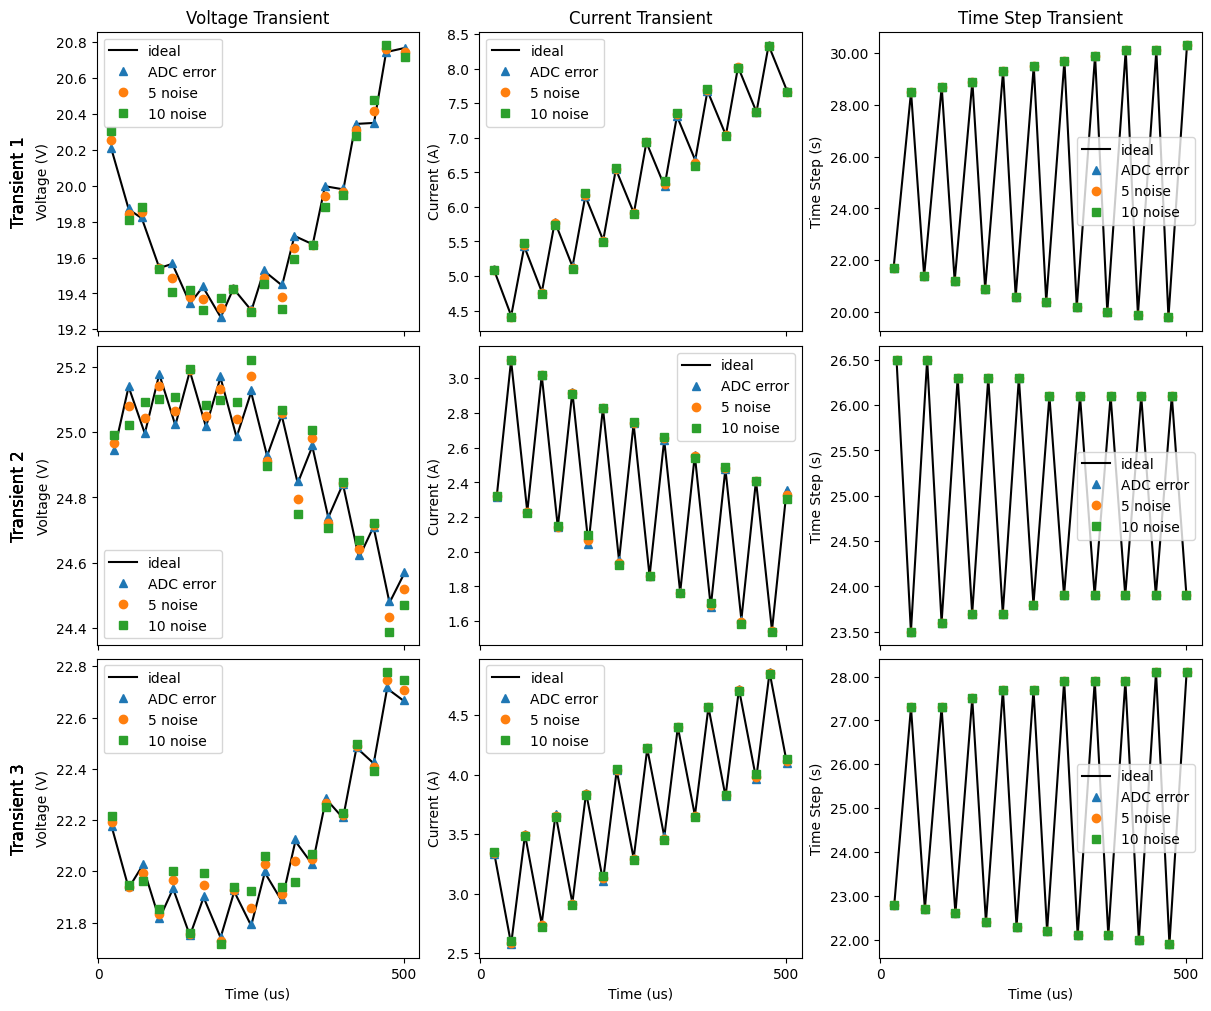

In [7]:
from pinn_buck.io import LoaderH5

ideal_sim = LoaderH5(db_dir, db_name)
ideal_sim.load(measurement_name="ideal")

adc_sim = LoaderH5(db_dir, db_name)
adc_sim.load(measurement_name="ADC_error")


noise5_sim = LoaderH5(db_dir, db_name)
noise5_sim.load(measurement_name="5 noise")

noise10_sim = LoaderH5(db_dir, db_name)
noise10_sim.load(measurement_name="10 noise")


slice_index = slice(0, 20)

ax = ideal_sim.M.plot_data(
    label="ideal",
    sharex=True,
    slice_index=slice_index,
    # include_D=True,
    # D_weight=1,
    legend=True,
    figsize=(12, 10),
    # legend_loc="upper left",
    color="black",
)

adc_sim.M.plot_data(
    label="ADC error",
    ax =ax,
    slice_index=slice_index,
    legend=True,
    markers="^",
    linestyle=" "
)

noise5_sim.M.plot_data(
    label="5 noise",
    ax=ax,
    slice_index=slice_index,
    legend=True,
    markers="o",
    linestyle=" "
)

noise10_sim.M.plot_data(
    label="10 noise",
    ax=ax,
    slice_index=slice_index,
    legend=True,
    markers="s",
    linestyle=" "
);


+ The ADC error has very little disturbing effect on the dataset
+ The 5 noise and 10 noise greatly disturb **the voltage data**, while the current data profile remains close to the ideal one

Note that the current has a wider span, covering several ampere! while the voltage only changes a few Volt. Therefore the impact of noise on the voltage is more evident.

#### Zoom out 
If we zoom out we can see a larger section of the transient:

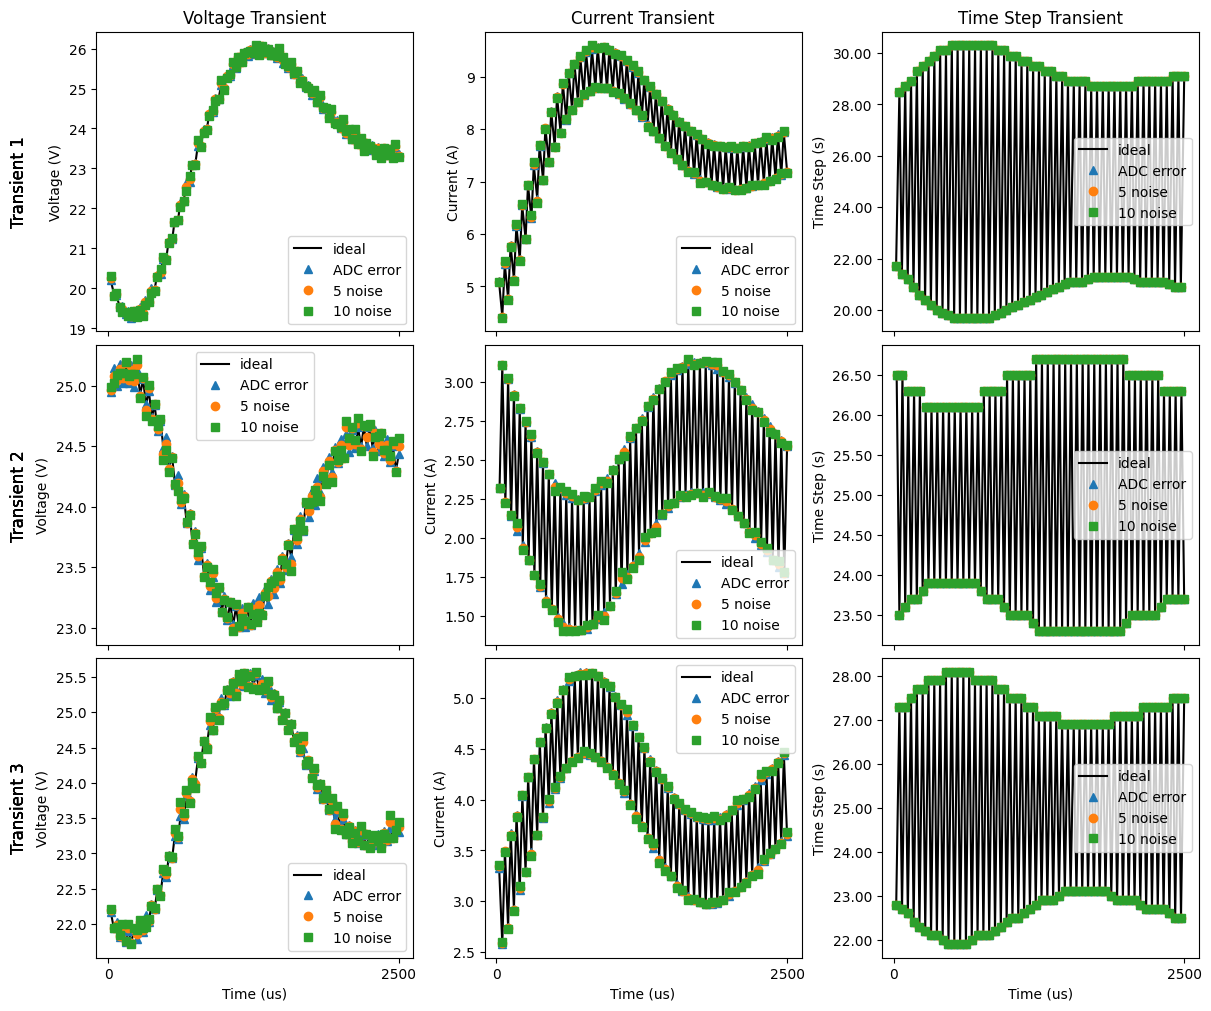

In [8]:
slice_index = slice(0, 100)

# ideal_sim = LoaderH5(db_dir, db_name)
# ideal_sim.load(measurement_name="ideal")

# adc_sim = LoaderH5(db_dir, db_name)
# adc_sim.load(measurement_name="ADC_error")


# noise5_sim = LoaderH5(db_dir, db_name)
# noise5_sim.load(measurement_name="5 noise")

# noise10_sim = LoaderH5(db_dir, db_name)
# noise10_sim.load(measurement_name="10 noise")

ax = ideal_sim.M.plot_data(
    label="ideal",
    sharex=True,
    slice_index=slice_index,
    # include_D=True,
    # D_weight=1,
    legend=True,
    figsize=(12, 10),
    # legend_loc="upper left",
    color="black",
)

adc_sim.M.plot_data(
    label="ADC error", ax=ax, slice_index=slice_index, legend=True, markers="^", linestyle=" "
)

noise5_sim.M.plot_data(
    label="5 noise", ax=ax, slice_index=slice_index, legend=True, markers="o", linestyle=" "
)

noise10_sim.M.plot_data(
    label="10 noise", ax=ax, slice_index=slice_index, legend=True, markers="s", linestyle=" "
);

## Generate my Noisy Data

It is important for continuing the research that we understand how the noise was generated and are able to build noisy datasets ourselves.

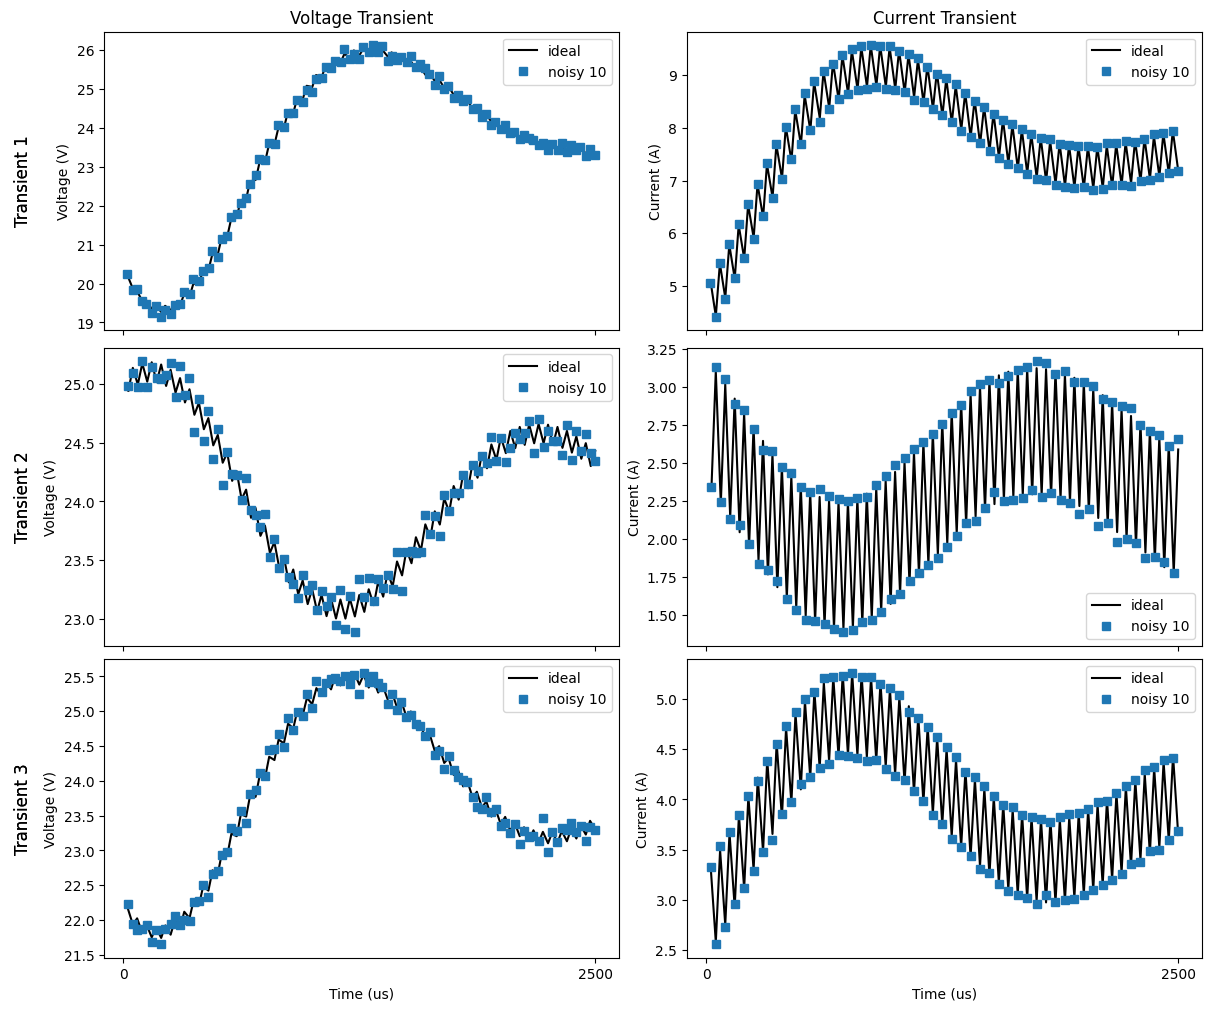

In [8]:
# the noisy data is obtained by adding noise to the ideal data of current and voltage, the switching and dt are not affected
from pinn_buck.io import TransientData, Measurement
from pinn_buck.noise import add_noise_to_Measurement


# Create noisy measurements
noisyM10 = add_noise_to_Measurement(ideal_sim.M, noise_level=10, V_FS=30, I_FS=10)

slice_index = slice(0, 100)

ax = ideal_sim.M.plot_data(
    label="ideal",
    sharex=True,
    slice_index=slice_index,
    # include_D=True,
    # D_weight=1,
    legend=True,
    figsize=(12, 10),
    # legend_loc="upper left",
    color="black",
    ignore_dt = True
)
noisyM10.plot_data(
    label="noisy 10",
    ax=ax,
    slice_index=slice_index,
    legend=True,
    markers="s",
    linestyle=" ",
    ignore_dt = True
);

Another consideration that arises from looking at these profiles is that the transient data with larger oscillations of the voltage might work best!


### Noisy Data in LSB

In the paper, ADC noise is 1 LSB, 5 noise is 5 LSB, 10 noise is 10 LSB.

A least significant bit (LSB) is the smallest unit of data in a digital system and is calculated as:
* LSB_i = I_FS / (2**12 - 1)  # assuming 12-bit ADC
* LSB_v = V_FS / (2**12 - 1)  # assuming 12-bit ADC

where I_FS is the full-scale current, set to 10 A and V_FS is the full-scale voltage set to 30 V (see 03_inspect_noisy_data.ipynb).

Then the noise level is calculated as:
* noise_level_i = noise_level * LSB_i  # normalize noise level to LSB
* noise_level_v = noise_level * LSB_v  # normalize noise level to LSB

Therefore, we can see why the current and voltage noises are different indeed, the full scale of the current oscilloscope is 10 A, while the voltage is 30 V. Therefore, although the noise affects the same number of LSBs, the entity of a current LSB and voltage LSB are different:
* lsb_i = 10 / (2**12 - 1)  # 10 A full-scale current
* lsb_v = 30 / (2**12 - 1)  # 30 V full-scale voltage